# Pull in data from Seattle Public Library and Create Figure 5

This notebook creates figure 5 comparing the publication dates between public library books and LFL books.
It also sets up the data files with the percent fiction and percent juvenile books per library branch.

In [1]:
#import the required libraries
import os
import csv
import requests
import json as json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import matplotlib.pyplot as plt
#is this needed?
%matplotlib inline 
from matplotlib import cm
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import scipy.stats as sps
import warnings

## The following are api calls that provide some useful information

In [ ]:
#Counts the number of books from 11/1/2019. Over 1.4 million
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&reportdate=2019-11-01T00:00:00.000
#get list of neighborhoods
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select distinct ItemLocation
#See number by a neightborhood
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&ItemLocation=cen
#I think we need: col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm (Madrona Sally Goaldman for central).
#None in Laurelhusrt
#This returns counts by location:
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation

#Not sure if this works    
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select count(BibNum) where ItemLocation=col OR ItemLocation=mon
    
    

## Skip to Analysis if you have files already

## Open json file

In [2]:
#Open up the files for reading
with open("SPL-bibCOUNTS-May2019.json", "r") as read_file: #Replace this with the filename of your choice
    jmay = json.load(read_file)
with open("SPL-bibCOUNTS-July2019.json", "r") as read_file: #Replace this with the filename of your choice
    jjuly = json.load(read_file)


## Get the number of books in branches


In [21]:
#This gets the recent ones for the neighborhoods and the date
coldate1 = '"2019-05-01T00:00:00.000"'
coldate2 = '"2019-07-01T00:00:00.000"'
may=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate1+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
july=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate2+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
jmay=json.loads(may.text) #parse the json into a list
jjuly=json.loads(july.text) #parse the json into a list


In [22]:
test = jmay +jjuly
print(len(test))
print(len(jmay))
print(len(jjuly))

65
33
32


In [23]:
#jmay[0]
jjuly[0]


{'ItemLocation': 'col', 'count_BibNum': '32701'}

## Save the json files

In [24]:
with open('SPL-bibCOUNTS-May2019.json', "w") as write_file:
    json.dump(jmay, write_file)
with open('SPL-bibCOUNTS-July2019.json', "w") as write_file:
    json.dump(jjuly, write_file)

## Get the count of books in your branches


In [39]:
#OLD data collection: col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm
#Better update: col, mon, qna, gwd, nga, net, mgm and dth (these two are for Central)
#Just to have the data, get net for May to compare with Laurelhurst
mayhoods = jmay #create a json file to mess with
julyhoods = jjuly

branches1=[] #dim list as a empty list

for c in mayhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='col':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='mgm':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='dth':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='qna':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='gwd':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='nga':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='net': #This is for laurelhurst
            branches1.append(c['count_BibNum'])

            
branches2=[] #dim list as a empty list

for c in julyhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='net': #This is for Ravenna
            branches2.append(c['count_BibNum'])
        if c['ItemLocation']=='mon':
            branches2.append(c['count_BibNum'])

print("List built:", len(branches1),"elements") #print how many elements are in lists
print("List built:", len(branches2),"elements")

List built: 7 elements
List built: 2 elements


In [40]:
#Convert the dictionary to a dataframe
bibctsmay = pd.DataFrame(branches1, columns=['bibcount'])
bibctsmay = pd.to_numeric(bibctsmay['bibcount'])

bibctsjuly = pd.DataFrame(branches2, columns=['bibcount'])
bibctsjuly = pd.to_numeric(bibctsjuly['bibcount'])

print(bibctsmay.head(10))
print(bibctsjuly.head(10))


0    31488
1    34276
2    51710
3    48137
4    23893
5    60289
6    10226
Name: bibcount, dtype: int64
0    16425
1    60672
Name: bibcount, dtype: int64


In [41]:
#This is needed to get the totals for the next part which is gathering the actual data
maybooks=bibctsmay.sum()
julybooks=bibctsjuly.sum()
print(maybooks)
print(julybooks)

260019
77097


# Retrieve Recent Records

### Open previous json if alread gathered, then skip to create CSV

In [3]:
#Open up the file for reading (this file location is on a harddrive because it's too big to push to GitHub)
with open("C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-Study-Data.json", "r") as read_file: #Replace this with the filename of your choice
    alldata = json.load(read_file)
count=len(alldata)
count

337116

## Collect the data

In [43]:
#This works in browser: https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= 'col' or ItemLocation='mon' or ItemLocation='qna' or ItemLocation='gwd' or ItemLocation='mgm' or ItemLocation='nga' or ItemLocation='uni' or ItemLocation='net' and reportdate='2019-11-01T00:00:00.000'&$limit=
#This gets the recent ones and limits the number to what was calculated above
s=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "col" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="qna" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="gwd" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="mgm" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="nga" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="net" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="dth" and reportdate="2019-05-01T00:00:00.000"&$limit='+str(maybooks)) #build string according to SOCRATA's convention to get public data assets
t=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "mon" and reportdate="2019-07-01T00:00:00.000" or ItemLocation="net" and reportdate="2019-07-01T00:00:00.000"&$limit='+str(julybooks)) #build string according to SOCRATA's convention to get public data assets

#Check this: https://stackoverflow.com/questions/42078161/python-appending-json-object-to-exisiting-json-object

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets


l=json.loads(s.text)
m=json.loads(t.text)
alldata= l + m
print(len(alldata))


337116


## Save the json file

In [44]:
with open('SPL-Study-Data.json', "w") as write_file:
    json.dump(alldata, write_file)

# Create CSV
dataframe created by transforming the alldata json file

#### Skip this if CSV is already created

In [45]:
metadata=open('SPL-Study-Data.csv', 'w', newline='', encoding='utf-8')
csv.writer(metadata).writerow(['bibnum','title','author','isbn','reportdate','publicationyear','itemtype','itemcollection','itemlocation'])

for i in alldata:
    csv.writer(metadata).writerow([i['bibnum'],
        i.get('title'),
        i.get('author'),
        i.get('isbn'),
        i.get('reportdate'),
        i.get('publicationyear'),
        i.get('itemtype'),
        i['itemcollection'],
        i['itemlocation']])                                  
        #i.get('isbn'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'.
                                   

metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf-8 error.  But here cp1252 produces an error!
df = pd.read_csv('SPL-Study-Data.csv',encoding='utf-8')

print('The resulting dataframe has',len(df),'rows')

The resulting dataframe has 337116 rows


In [46]:
df.head(1)

,bibnum,title,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation
0,2680854,Towers of midnight / Robert Jordan and Brandon...,"Jordan, Robert, 1948-2007","0765325942, 9780765325945",2019-05-01T00:00:00.000,2010.,acbk,nasf,dth


In [2]:
#Open previously created csv file if needed:
#This is raw data
df = pd.read_csv('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-Study-Data.csv',encoding='utf-8')

## Open data dictionary file to map fiction/nonfiction and media type

In [3]:
#Get the datadictionary
dftype = pd.read_csv('SPL-datadict-type.csv',encoding='utf-8')
dftype.head(2)

,itemtype,format
0,acart,Art
1,acphoto,Art


In [4]:
#Create a new dataframe with the data dictionary info type. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(df, dftype, on='itemtype', how='inner')

In [5]:
dfcol = pd.read_csv('SPL-datadict-collection.csv',encoding='utf-8')
dfcol.head(2)

,itemcollection,type
0,ncenf,Nonfiction
1,cabob,NaN


In [6]:
#Create a new dataframe with the data dictionary info collection. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(dfall, dfcol, on='itemcollection', how='inner')

In [7]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337116 entries, 0 to 337115
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   bibnum           337116 non-null  int64 
 1   title            337115 non-null  object
 2   author           290629 non-null  object
 3   isbn             297979 non-null  object
 4   reportdate       337116 non-null  object
 5   publicationyear  336805 non-null  object
 6   itemtype         337116 non-null  object
 7   itemcollection   337116 non-null  object
 8   itemlocation     337116 non-null  object
 9   format           337094 non-null  object
 10  type             336556 non-null  object
dtypes: int64(1), object(10)
memory usage: 30.9+ MB


## Pare down to books

In [9]:
dfbook = dfall.loc[(dfall['format']=='Book') | (dfall['format']=='Audiobook Disc')]
#adding in the audiobook disc adds 13 items to the list. LFL list includes audio books.

In [10]:
dfbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279696 entries, 0 to 337100
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   bibnum           279696 non-null  int64 
 1   title            279696 non-null  object
 2   author           267360 non-null  object
 3   isbn             277534 non-null  object
 4   reportdate       279696 non-null  object
 5   publicationyear  279451 non-null  object
 6   itemtype         279696 non-null  object
 7   itemcollection   279696 non-null  object
 8   itemlocation     279696 non-null  object
 9   format           279696 non-null  object
 10  type             279511 non-null  object
dtypes: int64(1), object(10)
memory usage: 25.6+ MB


## Add neighborhood column

In [11]:
dfhood = pd.read_csv('neighborhoods.csv',encoding='utf-8')
dfhood.head(2)

,itemlocation,reportdate,neighborhood,count
0,col,2019-05-01T00:00:00.000,Columbia City,1
1,mon,2019-07-01T00:00:00.000,Montlake,1


In [12]:
#Create a new dataframe with the neighborhood info. Inner join is intersection so removes rows with no partner in other dataframe
#Laurelhurst needs data from net in may, Ravenna from net in July, that's why reportdate is needed
dfbook = pd.merge(dfbook, dfhood, on=['itemlocation', 'reportdate'], how='inner')

In [13]:
dfbook.itemtype.unique()

array(['acbk', 'jcbk', 'bcbk', 'ucunkn', 'arbk', 'jrbk', 'pkbknh', 'ahbk',
       'ucunknj', 'jrmus', 'jcmus', 'bccd'], dtype=object)

# Clean book data

## Deal with the book year data issues

In [14]:
#Get a csv of the unique year values to look at problem values
dfyears = dfbook.publicationyear.unique()
dfyears = pd.DataFrame(dfyears)
dfyears.to_csv('SPLyears.csv', mode = 'w', index=False)

In [15]:
#Make sure all values are string (?) then get rid of all '[c', 'Â©' and then the rest of the brackets 
dfbook['publicationyear']= dfbook['publicationyear'].astype(str)
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[c',''),'')
#dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('Â©',''),'')
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[','').replace(']','')) 
#dfbook['publicationyear'] = preg_replace("/(©|&copy;|&#169;)/", "", dfbook['publicationyear'])
#dfbook['publicationyear'] = str_replace(array('©'), array(''), dfbook['publicationyear'])

In [16]:
#Create csv file to look at what date problems are left
#The cleaning seems to do a very good job.  Any blanks appear to be blank at SPL too.
dfbook.to_csv('SPL-book-data-cleaned.csv', mode = 'w', index=False)

In [17]:
#The year values are very difficult- lots of non numeric characters.
#Use: https://realpython.com/python-data-cleaning-numpy-pandas/#combining-str-methods-with-numpy-to-clean-columns

#reg expression: r'^(\d{4})'  This takes the first four numeric digits.  Everything else goes to NaN
dfbook['publicationyear'] = dfbook['publicationyear'].str.extract(r'^(\d{4})', expand=False)
dfbook.head()

,bibnum,title,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count
0,2680854,Towers of midnight / Robert Jordan and Brandon...,"Jordan, Robert, 1948-2007","0765325942, 9780765325945",2019-05-01T00:00:00.000,2010,acbk,nasf,dth,Book,Fiction,Central District,1
1,3406187,The city in the middle of the night / Charlie ...,"Anders, Charlie Jane","0765379961, 9780765379962, 9781466871137",2019-05-01T00:00:00.000,2019,acbk,nasf,dth,Book,Fiction,Central District,1
2,3023254,1634 : the Bavarian crisis / Eric Flint and Vi...,"Flint, Eric","1439132763, 9781439132760",2019-05-01T00:00:00.000,2009,acbk,nasf,dth,Book,Fiction,Central District,1
3,3126212,Barsk : the elephants' graveyard / Lawrence M....,"Schoen, Lawrence M.","0765377020, 9780765377029",2019-05-01T00:00:00.000,2015,acbk,nasf,dth,Book,Fiction,Central District,1
4,3284914,Provenance / Ann Leckie.,"Leckie, Ann","031638867X, 9780316388672",2019-05-01T00:00:00.000,2017,acbk,nasf,dth,Book,Fiction,Central District,1


In [20]:
#Convert to numeric and show datatype
dfbook['publicationyear'] = pd.to_numeric(dfbook['publicationyear'])
dfbook['publicationyear'].dtype

dtype('float64')

In [21]:
#What percent are Nan?
dfbook['publicationyear'].isnull().sum() / len(dfbook)

0.018845460785996224

In [22]:
len(dfbook)

279696

In [23]:
#The title and author are stored in the same variable separated by " / ".  Need to split those out.  There is an
#author variable as well but the values are stored in many different formats
#Rename title variable
dfbook.rename({'title': 'titleAuthor'}, axis=1, inplace=True)
#Split out title
dfbook['title'] = dfbook.titleAuthor.str.replace("( / ).*","")
#dfbook.head(1)

In [24]:
#Save csv file.  THIS IS THE WORKING DATAFILE FOR THE REST OF THIS NOTEBOOK
dfbook.to_csv('SPL-dfbook.csv', mode = 'w', index=False)

# ANALSYS
Should have a dfbook dataframe at this point

In [2]:
#Open a previous CSV
dfbook = pd.read_csv('SPL-dfbook.csv',encoding='utf-8')

In [3]:
#Open LFL year data
lflyear = pd.read_csv('../bookData/LFL-books-years.csv',encoding='utf-8')
lflyear.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang,combinedName
0,2019,1,0,1,Central District,CentralDistrict1,Nonfiction,Adult,Politics,Politics,POL,English,English,Human Rights Watch
1,2007,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Religion,Religion,R,English,English,William P. Young
2,2006,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Suspense,SUS,English,English,Dick Couch
3,1992,1,0,0,Central District,CentralDistrict1,Fiction,Adult,Suspense,Suspense,SUS,English,English,James Grady
4,1989,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Anthology/Essays/Short stories,AN,English,NaN,"Hollis Hodges, Loup Durand, Elliott Roosevelt ..."


### Histogram of years

In [15]:
lflyear['count'].sum()

1013

In [5]:
#Earliest year
dftemp = dfbook.sort_values(by='publicationyear', ascending=True).reset_index()
dftemp.head(1)

,index,bibnum,titleAuthor,author,isbn,reportdate,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count,title
0,19441,952642,The religious instruction of the Negroes in th...,"Jones, Charles Colcock, 1804-1863",NaN,2019-05-01T00:00:00.000,1842.0,acbk,naaanf,dth,Book,Nonfiction,Central District,1,The religious instruction of the Negroes in th...


In [118]:
#Set up a dataset with years going back as far as LFLs- Want to compare apples to apples

#IGNORE THIS - NO REASON TO REMOVE DATA

#dfbookyr = dfbook.loc[dfbook['publicationyear']>1927]
#print("Original:",len(dfbook)," New dataset:",len(dfbookyr))
#dfbookyr.head()

In [7]:
#Create one dataframe for year analysis

#Drop nan year values for public library dataset and convert to int64
splprep = dfbook[['publicationyear','neighborhood']].copy()
splprep['source'] = 'spl' #add a column to label this series
splprep = splprep.dropna() #there are some nan values, drop them
splprep = splprep.astype({'publicationyear': 'int64'})
#Prep LFL year data
lflprep = lflyear[['yrpub', 'neighborhood']].copy()
lflprep['source'] = 'lfl'
lflprep.rename(columns={'yrpub': 'publicationyear'}, inplace=True)
dfbookyrs = splprep.append(lflprep, ignore_index=True)
dfbookyrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275438 entries, 0 to 275437
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   publicationyear  275438 non-null  int64 
 1   neighborhood     275438 non-null  object
 2   source           275438 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.3+ MB


(1960.0, 2020.0)

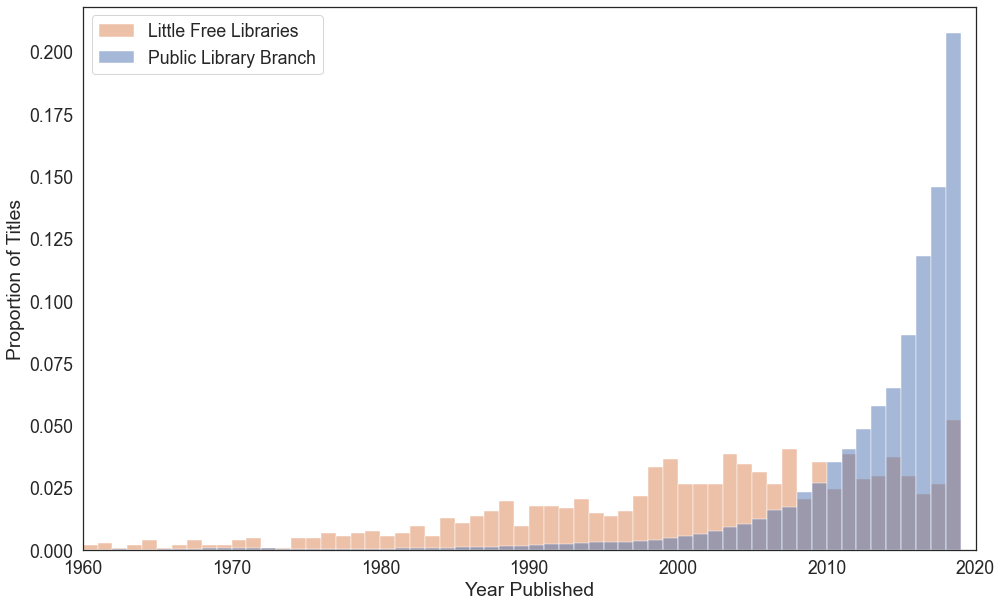

In [8]:
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='white', palette="deep", font_scale=1.6, rc={"figure.figsize": [16, 10]})
bin_num = dfbookyrs['publicationyear'].max() - dfbookyrs['publicationyear'].min()

sns.histplot(data=dfbookyrs, x='publicationyear', hue='source', stat='probability', legend = False, common_norm=False, bins=bin_num)


#SPL
#spldata = dfbookyrs[dfbookyrs['source']=='spl']
#p1= sns.distplot(
#    dfbook['publicationyear'], norm_hist=True, kde=False, bins=bin_num, color="black", hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
#LFL
#lfldata = dfbookyrs[dfbookyrs['source']=='lfl']

#p1= sns.distplot(
#    lflyear['yrpub'], norm_hist=True, kde=False, bins=bin_num, color="gray", hist_kws={"alpha": 0.75}).set(xlabel='Year Published', ylabel='Proportion')

plt.legend(labels=['Little Free Libraries','Public Library Branch'])
plt.ylabel('Proportion of Titles')
plt.xlabel('Year Published')
plt.xlim(1960, 2020)

In [9]:
hoods = pd.DataFrame(dict(neighborhood=dfbook.neighborhood.unique()))
hoods = hoods.sort_values(by=['neighborhood'])
hoods.head(8)


,neighborhood
0,Central District
5,Columbia City
3,Laurelhurst
7,Montlake
4,Northgate
1,Phinney-Greenwood
2,Queen Anne
6,Ravenna


In [10]:
for h in hoods['neighborhood']:
    hood=h
    print(hood)


Central District
Columbia City
Laurelhurst
Montlake
Northgate
Phinney-Greenwood
Queen Anne
Ravenna


## Figure 5
There are two ways to make this, one using Seaborn histplot and one using matplotlib hist

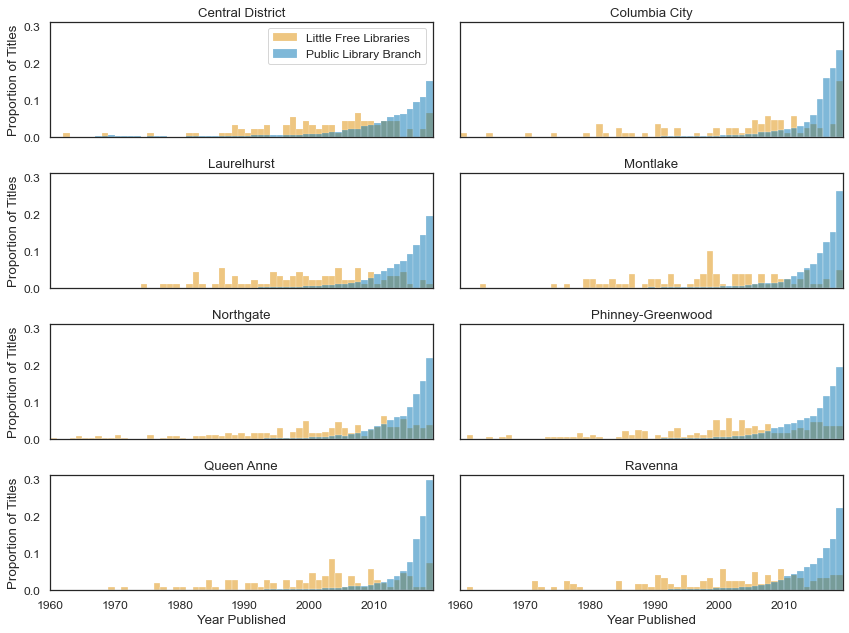

In [11]:
# BY NEIGHBORHOOD using Seaborn. Use this one.

sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 9]}) #This makes the chart nicer format
sns.set_palette('colorblind')

n_bins= np.arange(1959.5,2019.5,1) #Sets the bin ranges explicitly so all the bars line up

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout = True)
#fig.subplots_adjust(hspace=0.7, wspace=0.4)

#Create the first chart with a legend
hood0 = hoods['neighborhood'][0]
yrdata = dfbookyrs[dfbookyrs['neighborhood'] == hood0]
#Set bins based on years represented:
bin_num = yrdata['publicationyear'].max() - yrdata['publicationyear'].min()
#Create chart
sns.histplot(ax=axs[0,0], data=yrdata, x='publicationyear',hue='source', stat='probability', legend = False, common_norm=False, bins=bin_num)
axs[0,0].set_title(hood0)
axs[0,0].legend(labels=['Little Free Libraries','Public Library Branch'])
axs[0,0].set_xlim(1960,2019)

#Create the other seven charts, none with a legend
hoodschart = hoods[1:] #Create list of last seven neighborhoods
row = [0,1,1,2,2,3,3] #row, col, and counter help locate each chart in the overall figure.
col = [1,0,1,0,1,0,1]
counter = 0
for h in hoodschart['neighborhood']:
    hood = h
    rownum = row[counter]
    colnum = col[counter]
    yrdata = dfbookyrs[dfbookyrs['neighborhood'] == hood]
    #Set bins based on years represented:
    bin_num = yrdata['publicationyear'].max() - yrdata['publicationyear'].min()
    #Create chart
    sns.histplot(ax=axs[rownum,colnum], data=yrdata, x='publicationyear',hue='source', stat='probability', legend = False, common_norm=False, bins=bin_num)
    axs[rownum,colnum].set_title(hood)
    axs[rownum,colnum].set_xlim(1960,2019)
    
    counter+=1

#Apply labels only to the outside
for ax in axs.flat:
    ax.set(ylabel='Proportion of Titles', xlabel='Year Published')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#Save figure 
plt.set_loglevel('error') #This changes changes logging so you don't see eps transparency warning: https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.set_loglevel
plt.savefig('../figures/pub-dates-comparison-colorblind.eps', dpi=300, format="eps") #use transparent=True, to set background transparent
plt.savefig('../figures/pub-dates-comparison-colorblind.png', dpi=300, format="png")

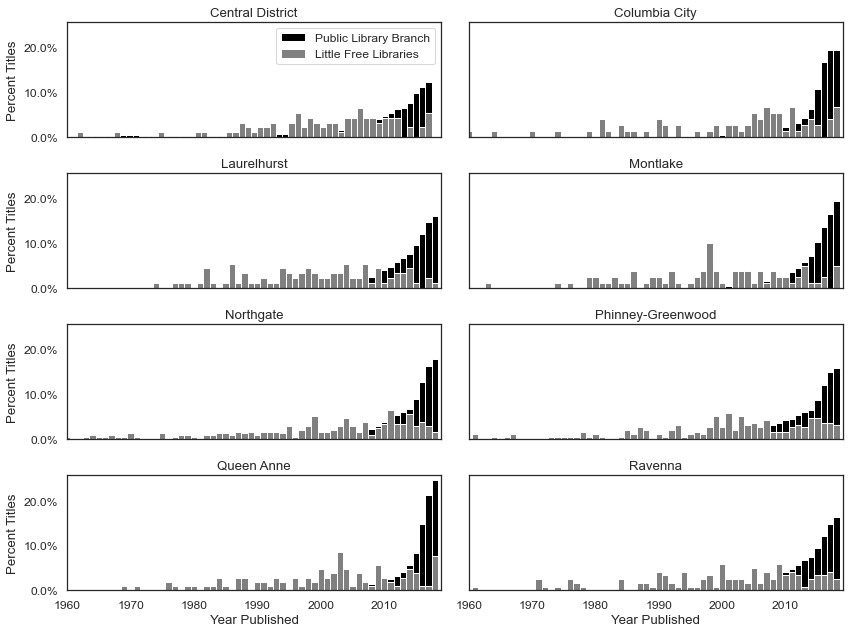

In [126]:
# BY NEIGHBORHOOD using matpltlib

sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 9]}) #This makes the chart nicer format

n_bins= np.arange(1959.5,2019.5,1) #Sets the bin ranges explicitly so all the bars line up

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout = True)
#fig.subplots_adjust(hspace=0.7, wspace=0.4)

#Create the first chart with a legend
hood0 = hoods['neighborhood'][0]
hooddata = dfbookyrs[dfbookyrs['neighborhood']==hood0]
bin_num= np.arange(hooddata['publicationyear'].min()-0.5,hooddata['publicationyear'].max()+0.5,1) #Sets the bin ranges explicitly so all the bars line up
dfbookyrcol = hooddata[hooddata['source']=='spl']
lflyearcol = hooddata[hooddata['source']=='lfl']

#SPL
axs[0,0].hist(dfbookyrcol['publicationyear'], bins=bin_num, density=True, color="black")
#LFL
axs[0,0].hist( lflyearcol['publicationyear'], bins=n_bins, density=True, color="gray") #Use alpha=0.5 for transparency

#Create line for SPL histogram. This takes a while to calculate and create. Be patient
#x = np.linspace(1960, 2020, len(dfbookyrcol['publicationyear'])+1)
#kde = sps.gaussian_kde(dfbookyrcol['publicationyear']) 
#axs[0].plot(x,kde.pdf(x), color="black")

# Now we format the y-axis to display percentage
axs[0,0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0,0].set_title(hood0)
axs[0,0].legend(labels=['Public Library Branch','Little Free Libraries'])
axs[0,0].set_xlim(1960,2020)

#Create the other seven charts, none with a legend
hoodschart = hoods[1:] #Create list of last seven neighborhoods
row = [0,1,1,2,2,3,3] #row, col, and counter help locate each chart in the overall figure.
col = [1,0,1,0,1,0,1]
counter = 0
for h in hoodschart['neighborhood']:
    hood = h
    rownum = row[counter]
    colnum = col[counter]
    
    hooddata = dfbookyrs[dfbookyrs['neighborhood']==hood]
    bin_num= np.arange(hooddata['publicationyear'].min()-0.5,hooddata['publicationyear'].max()+0.5,1) #Sets the bin ranges explicitly so all the bars line up
    dfbookyrcol = hooddata[hooddata['source']=='spl']
    lflyearcol = hooddata[hooddata['source']=='lfl']
    
    #SPL
    axs[rownum,colnum].hist(dfbookyrcol['publicationyear'], bins=bin_num, density=True, color="black")
    #LFL
    axs[rownum,colnum].hist( lflyearcol['publicationyear'], bins=n_bins, density=True, color="gray") #Use alpha=0.5 for transparency
    
    # Now we format the y-axis to display percentage
    axs[rownum,colnum].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axs[rownum,colnum].set_title(hood)
    axs[rownum,colnum].set_xlim(1960,2019)
    
    counter+=1

#Apply labels only to the outside
for ax in axs.flat:
    ax.set(ylabel='Percent Titles', xlabel='Year Published')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#Save figure 
plt.set_loglevel('error') #This changes changes logging so you don't see eps transparency warning: https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.set_loglevel
plt.savefig('../figures/pub-dates-comparison.eps', dpi=300, format="eps")
plt.savefig('../figures/pub-dates-comparison.png', dpi=300, format="png")

### Calculate Cumulative Percentage
This is used to see what year and above represents 90% of the books

#### SPL

In [45]:
#Groups by pub year 
dfSPLyr = dfbook.groupby(['publicationyear'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfSPLyr = dfSPLyr.sort_values(by='publicationyear', ascending=False).reset_index()

In [46]:
dfSPLyr['cumulative']=dfSPLyr['count'].cumsum()/dfSPLyr['count'].sum()
dfSPLyr.head(20)

,index,publicationyear,count,cumulative
0,114,2019.0,13687,0.049875
1,113,2018.0,43310,0.207696
2,112,2017.0,39947,0.353262
3,111,2016.0,32406,0.471349
4,110,2015.0,23696,0.557697
5,109,2014.0,17863,0.622789
6,108,2013.0,15833,0.680485
7,107,2012.0,13403,0.729325
8,106,2011.0,11109,0.769806
9,105,2010.0,9671,0.805047


### Try it the opposite way
So you can say __% of books published before 2006 or whatever

In [4]:
#Groups by pub year 
dfSPLyr_opp = dfbook.groupby(['publicationyear'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfSPLyr_opp = dfSPLyr_opp.sort_values(by='publicationyear', ascending=True).reset_index()

In [7]:
dfSPLyr_opp['cumulative']=dfSPLyr_opp['count'].cumsum()/dfSPLyr_opp['count'].sum()
dfSPLyr_opp.tail(20)

,index,publicationyear,count,cumulative
95,95,2000.0,1585,0.064251
96,96,2001.0,1789,0.070770
97,97,2002.0,2140,0.078568
98,98,2003.0,2603,0.088053
99,99,2004.0,2917,0.098683
100,100,2005.0,3430,0.111182
101,101,2006.0,4415,0.127270
102,102,2007.0,4770,0.144652
103,103,2008.0,6369,0.167860
104,104,2009.0,7435,0.194953


#### LFL

In [11]:
#Create new dataframe
dfLFLyr=lflyear

In [12]:
#Groups by pub year 
dfLFLyr = dfLFLyr.groupby(['yrpub'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfLFLyr = dfLFLyr.sort_values(by='yrpub', ascending=False).reset_index()

In [49]:
total = dfLFLyr['count'].sum()
print(total)

1013


In [50]:
dfLFLyr['cumulative']=dfLFLyr['count'].cumsum()/dfLFLyr['count'].sum()
dfLFLyr.head(40)

,index,yrpub,count,cumulative
0,67,2019,16,0.015795
1,66,2018,36,0.051333
2,65,2017,27,0.077986
3,64,2016,23,0.100691
4,63,2015,30,0.130306
5,62,2014,40,0.169793
6,61,2013,30,0.199408
7,60,2012,29,0.228036
8,59,2011,39,0.266535
9,58,2010,25,0.291214


In [15]:
#Groups by pub year 
dfLFLyr_opp = dfLFLyr.groupby(['yrpub'])['count'].sum().reset_index() #total of each category
#Sort high to low
dfLFLyr_opp = dfLFLyr_opp.sort_values(by='yrpub', ascending=True).reset_index()

In [16]:
dfLFLyr_opp['cumulative']=dfLFLyr_opp['count'].cumsum()/dfLFLyr_opp['count'].sum()
dfLFLyr_opp.tail(20)

,index,yrpub,count,cumulative
48,48,2000,27,0.428430
49,49,2001,27,0.455084
50,50,2002,27,0.481737
51,51,2003,39,0.520237
52,52,2004,35,0.554788
53,53,2005,32,0.586377
54,54,2006,27,0.613031
55,55,2007,41,0.653504
56,56,2008,21,0.674235
57,57,2009,36,0.709773


# Set up a dataframe with SPL data by neighborhood
fiction/nonfiction, percent children

In [51]:
dfbook.type.unique()

array(['Fiction', 'Nonfiction', 'Language', 'Reference', nan],
      dtype=object)

### Percent Fiction

In [52]:
#Set up a dataframe with the percent fiction

#Groups count by Neighborhood, and type, calculates percent
bksfiction = dfbook.groupby(['neighborhood', 'type'])['count'].sum().reset_index() #total of each category
bksfiction['total'] = bksfiction.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood 
bksfiction['percent'] = bksfiction['count']/bksfiction['total']


#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction']
fic.head(8)

,neighborhood,type,count,total,percent
0,Central District,Fiction,23003,49029,0.469171
4,Columbia City,Fiction,14870,26486,0.561429
8,Laurelhurst,Fiction,29836,50942,0.585686
12,Montlake,Fiction,7731,13001,0.594647
15,Northgate,Fiction,16174,27569,0.586673
19,Phinney-Greenwood,Fiction,22772,42934,0.530395
23,Queen Anne,Fiction,10197,18491,0.551457
27,Ravenna,Fiction,29569,51059,0.579114


In [53]:
fictionbks = fic['count'].sum()
totalbks = fic['total'].sum()
perfic = fictionbks/totalbks
print(perfic)

0.551506023018772


In [54]:
#Save csv file
fic.to_csv('SPL-fiction.csv', mode = 'w', index=False)

### Percent Juvenile

In [55]:
dfbook.itemtype.unique()


array(['acbk', 'jcbk', 'bcbk', 'ucunkn', 'arbk', 'jrbk', 'pkbknh', 'ahbk',
       'ucunknj', 'jrmus', 'jcmus', 'bccd'], dtype=object)

In [56]:
#Set up a dataframe with the juvenile books. Uses the dfbook dataframe saved before analysis

#Groups count by Neighborhood, and itemtype, calculates percent
bksage = dfbook.groupby(['neighborhood', 'itemtype'])['count'].sum().reset_index() #total of each category
bksage['ageletter'] = bksage['itemtype'].str[:1] #selects first letter of itemtype code (a=adult and YA, j=juvenile)
bksagelist = bksage.groupby(['neighborhood','ageletter'])['count'].apply(lambda x : x.astype(int).sum()) #sums up the a's and j's by neighborhood
bksage = pd.DataFrame(bksagelist).reset_index()
bksage['total'] = bksage.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood

bksage['percent'] = bksage['count']/bksage['total']

bksage.head()


,neighborhood,ageletter,count,total,percent
0,Central District,a,28750,49029,0.586388
1,Central District,b,7,49029,0.000143
2,Central District,j,20115,49029,0.410267
3,Central District,p,148,49029,0.003019
4,Central District,u,9,49029,0.000184


In [57]:
#Select juveniles
bksjuv = bksage.loc[bksage['ageletter']=='j']
bksjuv.head(8)


,neighborhood,ageletter,count,total,percent
2,Central District,j,20115,49029,0.410267
7,Columbia City,j,11587,26486,0.437476
11,Laurelhurst,j,23079,50942,0.453045
15,Montlake,j,6266,13006,0.481778
19,Northgate,j,11591,27569,0.420436
23,Phinney-Greenwood,j,18297,42934,0.426166
27,Queen Anne,j,7791,18491,0.421340
31,Ravenna,j,22990,51239,0.448682


In [58]:
#Save csv file
bksjuv.to_csv('SPL-juvenilePercent.csv', mode = 'w', index=False)

## Compare ISBNs

In [59]:
#Open LFL raw book data and open SPL data if needed
dflfl = pd.read_csv('../bookData/bookData.csv')
dfbook = pd.read_csv('SPL-dfbook.csv',encoding='utf-8')

In [60]:
#Pare down to neighborhood and isbn columns
lfl = dflfl[['neighborhood','isbn','yrpub']].copy()
spl = dfbook[['neighborhood','isbn']].copy()

In [61]:
#remove duplicate LFL books within each neighborhood. 22 entries are removed leaving 991 rows
lfl = lfl.drop_duplicates(subset=['neighborhood','isbn'], keep='first')

In [62]:
#Convert isbn variable to string
spl['isbn'] = spl['isbn'].astype('str')

In [63]:
#The SPL data has many isbns all in the same column.  Parse them out.
#I got this from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
#First get needed packages 
import numpy as np
from itertools import chain

In [64]:
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = spl['isbn'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
splisbn = pd.DataFrame({'neighborhood': np.repeat(spl['neighborhood'], lens),
                    'isbn': chainer(spl['isbn'])})

In [65]:
#The isbn column has apostrophes and an occasional 'b'. Remove them
splisbn['isbn'] = splisbn['isbn'].str.replace(r"[b\',]", '')

In [66]:
#Reset the index
splisbn.reset_index(drop=True,inplace=True)

In [67]:
#Merge dataframes to get isbns present in lfl and spl. The new dataframe has a column renamed to splhood that shows a 
#value if the isbn is present at that library branch
shared = pd.merge(lfl, splisbn, on='isbn', how='inner')
shared.rename(columns={"neighborhood_x": "neighborhood", "neighborhood_y": "splhood"}, inplace=True)

In [68]:
len(shared)

83

In [69]:
#Save file if you want
shared.to_csv('isbn-matching.csv', mode = 'w', index=False)

In [70]:
#The shared dataframe includes multiple rows for an isbn that is in an LFL if that isbn is found in multiple SPL branches
shared.head()

,neighborhood,isbn,yrpub,splhood
0,Columbia City,1101904429,2019,Queen Anne
1,Columbia City,1101904429,2019,Northgate
2,Columbia City,1101904429,2019,Montlake
3,Northgate,1487001835,2018,Northgate
4,Montlake,1631494139,2018,Phinney-Greenwood


In [71]:
#Count the branches for each isbn. One book is in all branches and Central District includes two branches so 9.
sharedbooks = shared.groupby(['isbn'])['splhood'].count().reset_index()
sharedbooks.sort_values(by='splhood', ascending=False, inplace=True)
sharedbooks.head()

,isbn,splhood
29,198480183X,9
14,1501187597,7
2,067989067X,7
7,144248845X,7
25,1641290110,5


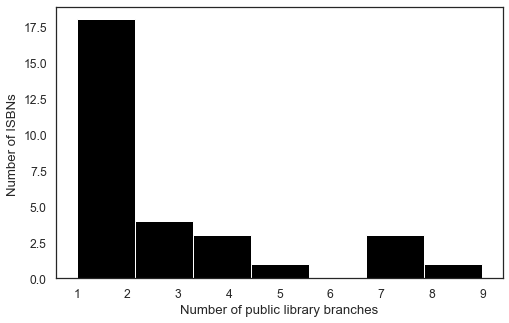

In [72]:
# Histogram of the number of ISBNs existing in an LFL that are also represented in one or more SPL library branches
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

#SPL
p1= sns.distplot(
    sharedbooks['splhood'], norm_hist=False, kde=False, bins=7, color='black', hist_kws={"alpha": 1}).set(xlabel='Number of public library branches', ylabel='Number of ISBNs ')


In [73]:
#Count isbns that are present in at least one SPL branches
len(sharedbooks)

30

In [74]:
#Count times the LFL books are in the nearby branch. Only five neighborhoods had books in LFLs that were present 
#in the nearby public library branch
samehood= shared[shared['splhood']==shared['neighborhood']].groupby(['splhood']).count().reset_index()
samehood.head(10)

,splhood,neighborhood,isbn,yrpub
0,Laurelhurst,1,1,1
1,Northgate,2,2,2
2,Phinney-Greenwood,2,2,2
3,Queen Anne,1,1,1
4,Ravenna,3,3,3


In [75]:
#See what year the shared books were published
years = shared[shared['splhood']==shared['neighborhood']]
years.head(10)

,neighborhood,isbn,yrpub,splhood
3,Northgate,1487001835,2018,Northgate
22,Phinney-Greenwood,1641290110,2018,Phinney-Greenwood
29,Queen Anne,144248845X,2014,Queen Anne
34,Northgate,1472906500,2014,Northgate
46,Ravenna,1603093680,2015,Ravenna
49,Ravenna,1338068474,2018,Ravenna
54,Phinney-Greenwood,198480183X,2018,Phinney-Greenwood
68,Laurelhurst,1335474625,2018,Laurelhurst
74,Ravenna,1606840355,2010,Ravenna


## Get all the isbns from May and July to compare
That is get all the ISBNs available at SPL

In [85]:
#IF RUNNING AGAIN, OPEN EXISTING FILE AND GO TO ANALYZE ISBN SECTION
splallisbn2 = pd.read_csv('SPL-isbn-clean.csv',encoding='utf-8')

In [76]:
#Use previous json files

#Get count of all SPL isbns for May
with open("SPL-bibCOUNTS-May2019.json", "r") as read_file: 
    may = json.load(read_file)

maylist=[]
for c in may:  
            maylist.append(c['count_BibNum'])

#Get count of all SPL isbns for July 
with open("SPL-bibCOUNTS-July2019.json", "r") as read_file: 
    july = json.load(read_file)

julylist=[]
for c in july:  
            julylist.append(c['count_BibNum'])
        
#Convert the dictionaries to a dataframes
bibctsMay = pd.DataFrame(maylist, columns=['bibcount'])
bibctsMay = pd.to_numeric(bibctsMay['bibcount'])

bibctsJuly = pd.DataFrame(julylist, columns=['bibcount'])
bibctsJuly = pd.to_numeric(bibctsJuly['bibcount'])

#Sum the lists
bibMay = bibctsMay.sum()
bibJuly = bibctsJuly.sum()

print("May ISBNs: ", bibMay, " July ISBNs: ", bibJuly)

May ISBNs:  1324806  July ISBNs:  1486646


In [ ]:
#Get isbns from SPL-
#Dates of data:
coldate1 = '"2019-05-01T00:00:00.000"'
coldate2 = '"2019-07-01T00:00:00.000"'

#Collect data
s=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=isbn&$where=reportdate='+coldate1+'&$limit='+str(bibMay)) 
m=json.loads(s.text)

t=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=isbn&$where=reportdate='+coldate2+'&$limit='+str(bibJuly)) 
j=json.loads(t.text)
               
print(len(m)," ",len(j))

In [12]:
#Save the files - Saving them to a non Github folder since they are really big and need to get cleaned up
with open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-may2019-isbns.json', "w") as write_file:
    json.dump(m, write_file)
with open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-july2019-isbns.json', "w") as write_file:
    json.dump(j, write_file)

In [13]:
#Create a dataframe for spl data and combine the json files- There are blank entries in here.
metadata=open('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-isbn.csv', 'w', newline='', encoding='utf-8')
csv.writer(metadata).writerow(['isbn'])

for i in m:
    csv.writer(metadata).writerow([i])

for i in j:
    csv.writer(metadata).writerow([i])
  
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe.
splallisbn = pd.read_csv('C:/Users/Andre/Documents/Research/Free_little_lib/DataAnalysis/SPL/SPL-isbn.csv',encoding='utf-8')

In [80]:
#Convert isbn variable to string
splallisbn['isbn'] = splallisbn['isbn'].astype('str')

In [81]:
#The SPL data has many isbns all in the same column.  Parse them out.
#I got this from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
#First get needed packages 
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = splallisbn['isbn'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
splallisbn2 = pd.DataFrame({'isbn': chainer(splallisbn['isbn'])})

#The isbn column has apostrophes and an occasional 'b'. Remove them
splallisbn2['isbn'] = splallisbn2['isbn'].str.replace(r"[b\',]", '')
#Turns out it also has "isn:" and some curly brackets. Remove them
splallisbn2['isbn'] = splallisbn2['isbn'].str.replace(r"[isn: /{/},]", '')

#Reset the index
splallisbn2.reset_index(drop=True,inplace=True)

#Cull duplicates- This takes it from 5 million isbns to 800K
splallisbn2 = splallisbn2.drop_duplicates()


In [82]:
#Remove the blank entry

splallisbn2 = splallisbn2[splallisbn2.isbn != '']


In [27]:
#Save file
splallisbn2.to_csv('SPL-isbn-clean.csv', mode = 'w', index=False)

In [30]:
splallisbn2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798714 entries, 0 to 5351027
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    798714 non-null  object
dtypes: object(1)
memory usage: 12.2+ MB


### Analyze ISBNs

In [2]:
#open spl data if needed
splallisbn2 = pd.read_csv('SPL-isbn-clean.csv')

In [3]:
#Open LFL raw book data
dflfl = pd.read_csv('../bookData/bookData.csv')

#Pare down to isbn columns
lfl1 = dflfl[['title','yrpub','isbn','age','type']].copy()
#Remove duplicates
lfl = lfl1.drop_duplicates() #removes 10 rows


In [4]:
#Merge dataframes to get isbns present in lfl and spl.
shared2 = pd.merge(lfl, splallisbn2, on='isbn', how='inner')
shared2 = shared2.sort_values(by=['yrpub'])
#Reset the index
shared2.reset_index(drop=True,inplace=True)
shared2['count'] = 1

In [5]:
print('Earliest: ', shared2['yrpub'][0], 'Last: ', shared2['yrpub'].tail(1)) #Note, tail outputs the index value too.

Earliest:  1954 Last:  118    2019
Name: yrpub, dtype: object


In [6]:
print('Total books shared by all of SPL and LFLs:',len(shared2))

Total books shared by all of SPL and LFLs: 119


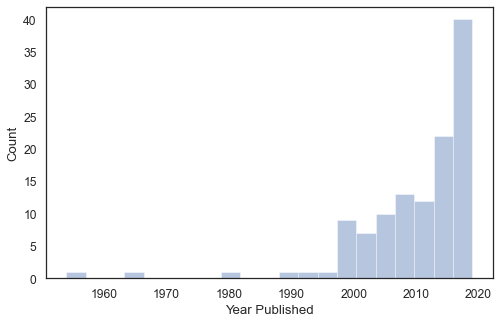

In [89]:
p=sns.distplot(shared2['yrpub'], bins=21, kde=False).set(xlabel='Year Published', ylabel='Count')

In [90]:
#Get a cumulative percent
sharedcumu = shared2.sort_values(by=['yrpub'], ascending=False)
#Reset the index
sharedcumu.reset_index(drop=True,inplace=True)
#Add a count column and calculate cumulative percent (probably a better way to do this)
sharedcumu['count'] = 1
sharedcumu['cumulative']=sharedcumu['count'].cumsum()/sharedcumu['count'].sum()

In [91]:
#Looks like 90% of the books in LFLs and in all of SPL were published 2000 and later. 
sharedcumu.head(111)

,title,yrpub,isbn,age,type,count,cumulative
0,Message from the Shadows: Selected Stories,2019,1939810159,Adult,Fiction,1,0.008403
1,The Moth Presents Occasional Magic: True Stori...,2019,1101904429,Adult,Nonfiction,1,0.016807
2,"Maternal Desire: On Children, Love, and the In...",2019,1501198270,Adult,Nonfiction,1,0.025210
3,"Waking the Witch: Reflections on Women, Magic,...",2019,1982100702,Adult,Nonfiction,1,0.033613
4,Pretty Revenge,2019,1982122102,Adult,Fiction,1,0.042017
...,...,...,...,...,...,...,...
106,I'm a Stranger Here Myself: Notes on Returning...,2000,076790382X,Adult,Nonfiction,1,0.899160
107,Civil War On Sunday (Magic Tree House #21),2000,067989067X,Childrens,Fiction,1,0.907563
108,Daughter of Fortune: A Novel,1999,006019491X,Adult,Fiction,1,0.915966
109,A Home at the End of the World: A Novel,1998,9780312202316,Adult,Fiction,1,0.924370


In [92]:
#Groups by age
sharedage = shared2.groupby(['age'])['count'].count().reset_index() #total of each category
#Sort high to low
sharedage = sharedage.sort_values(by='count', ascending=False).reset_index()
sharedage['percent'] = sharedage['count']/sharedage['count'].sum()
sharedage.head()

,index,age,count,percent
0,0,Adult,89,0.747899
1,1,Childrens,21,0.176471
2,2,Young Adult,9,0.075630


In [93]:
#Groups by type
sharedtype = shared2.groupby(['type'])['count'].count().reset_index() #total of each category
#Sort high to low
sharedtype = sharedtype.sort_values(by='count', ascending=False).reset_index()
sharedtype['percent'] = sharedtype['count']/sharedtype['count'].sum()
sharedtype.head()

,index,type,count,percent
0,0,Fiction,76,0.638655
1,1,Nonfiction,43,0.361345
